# Environment Wrapper for Farm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mcts import MCTS
from agents import * 
import farmgame  # Ensure the farmgame module is imported
from farmgame import *
import statsmodels.api as sm

# Define the FarmEnv class
# class FarmEnv:
#     def __init__(self, farm: Farm, reward_function=None):
#         self.game = farm  # Accept a Farm instance directly
#         self.done = False
#         self.reward_function = reward_function or self.default_reward

#     def reset(self):
#         self.game = configure_game()  # Reset the game
#         self.done = False
#         return self.get_state()

#     def step(self, action):
#         current_player = self.game.whose_turn()["name"]
#         self.game = self.game.take_action(action, inplace=True)  # Apply action
#         reward = self.reward_function(self.game, current_player)  # Calculate reward
#         self.done = self.game.is_done()  # Check if game is done
#         new_state = self.get_state()  # Get the updated state
#         return new_state, reward, self.done, {}  # Return updated state

#     def get_state(self):
#         return self.map

#     def render(self):
#         self.game.print_farm()

#     def default_reward(self, game, player):
#         return game.playersDict[player]["score"]

# Training

In [2]:
#score used throughout, reward used at end?

In [11]:
class QLearningAgent:
    def __init__(self, learning_rate, discount_factor, epsilon, color, seed=None):
        self.q_table = {}  # Dictionary to store Q-values
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.color = color

        # Random seed for reproducibility (optional)
        self.seed = seed or random.randint(0, 1e6)
        random.seed(self.seed)

        self.current_state = None  # Track the latest full state

    def update(self, state):
        self.current_state = state  # Keep the full state object

    def get_state_representation(self, state):
        """
        Convert the state into a hashable representation for the Q-table.
        Assuming 'state' is an object with properties that can be converted to hashable types.
        """
        # Example: Convert agent positions and other attributes to tuples
        if self.color == "red":
            player = state.redplayer
        else:
            player = state.purpleplayer
#         agents = tuple((player['loc']['x'], player['loc']['y'], player['name']))
#         energy_levels = player['energy']
#         items = tuple((item.loc['x'], item.loc['y'], item.color) for item in state.items)
#         backpacks = tuple((player['backpack']['capacity'], len(player['backpack']['contents'])))
        agents = tuple((player['loc']['x'], player['loc']['y']))
        energy_levels = player['energy']
        items = tuple((item.loc['x'], item.loc['y']) for item in state.items if item.color == self.color and item.status == "farm")
        backpacks = player['backpack']['capacity']- len(player['backpack']['contents'])
        

        return (agents, energy_levels, items, backpacks)

    def get_action_representation(self, action):
        #return (action.type, action.color, action.loc['x'], action.loc['y'])  # Simplified action representation
        return (action.type, action.color)  # Simplified action representation


    def get_q_value(self, state, action):
        state_rep = self.get_state_representation(state)
        action_rep = self.get_action_representation(action)
        return self.q_table.get((state_rep, action_rep), 0.0)

    def choose_action(self):
        actions = self.current_state.legal_actions()
        if not actions:
            raise Exception("No legal actions available.")

        if random.random() < self.epsilon:  # Explore
            return random.choice(actions)

        q_values = [self.get_q_value(self.current_state, a) for a in actions]
        max_q_value = max(q_values)
        best_actions = [a for a, q in zip(actions, q_values) if q == max_q_value]
        return random.choice(best_actions)

    def update_q_value(self, action, reward, next_state):
        state_rep = self.get_state_representation(self.current_state)
        action_rep = self.get_action_representation(action)
        next_state_rep = self.get_state_representation(next_state)

        next_actions = next_state.legal_actions()
        #max_q_next = max([self.get_q_value(next_state_rep, a) for a in next_actions], default=0)
        max_q_next = max([self.get_q_value(next_state, a) for a in next_actions], default=0)

        td_target = reward + self.discount_factor * max_q_next
        td_error = td_target - self.get_q_value(self.current_state, action)

        new_q_value = self.get_q_value(self.current_state, action) + self.learning_rate * td_error
        self.q_table[(state_rep, action_rep)] = new_q_value

    def decay_epsilon(self, decay_rate=0.99):
        self.epsilon = max(0.01, self.epsilon * decay_rate)

def train_q_learning_agent(env, learning_rate, discount_factor, epsilon, num_episodes, max_steps_per_episode=100):
    agent1 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, color = "red")
    agent2 = QLearningAgent(learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, color = "purple")

    final_rewards_red = []
    final_rewards_purple = []
    helpful_moves_red = []
    helpful_moves_purple = []

    for episode in range(num_episodes):
        state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
        agent1.update(state)
        agent2.update(state)

        red_helpful_count = 0
        purple_helpful_count = 0

        for step in range(max_steps_per_episode):
            action1 = agent1.choose_action()
            transition = farmgame.Transition(state, action1)
            if transition.is_helping():
                red_helpful_count += 1

            next_state = state.take_action(action1, inplace=True)
            reward1, done = next_state.reward("red")
            agent1.update_q_value(action1, reward1, next_state)
            state = next_state

            if done:
                break

            action2 = agent2.choose_action()
            transition = farmgame.Transition(state, action2)
            if transition.is_helping():
                purple_helpful_count += 1

            next_state = state.take_action(action2, inplace=True)
            reward2, done = next_state.reward("purple")
            agent2.update_q_value(action2, reward2, next_state)
            state = next_state

            if done:
                break

        red_rwd, _ = state.reward("red")
        purple_rwd, _ = state.reward("purple")
        print(red_rwd, purple_rwd)
        final_rewards_red.append(red_rwd)
        final_rewards_purple.append(purple_rwd)

        helpful_moves_red.append(red_helpful_count)
        helpful_moves_purple.append(purple_helpful_count)

        agent1.decay_epsilon()
        agent2.decay_epsilon()

        if (episode + 1) % 100 == 0:
            avg_red_reward = sum(final_rewards_red[-100:]) / 100
            avg_purple_reward = sum(final_rewards_purple[-100:]) / 100
            print(f"Episode {episode + 1}: Avg Red Reward = {avg_red_reward}, Avg Purple Reward = {avg_purple_reward}")
            print(f"Avg Helpful Moves: Red = {sum(helpful_moves_red[-100:]) / 100}, Purple = {sum(helpful_moves_purple[-100:]) / 100}")

    print("\nTraining completed.")
    return agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple

TheFarm = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
state = TheFarm

done = False
learning_rate = 0.3
discount_factor = 0.9
epsilon = 0.8
agent1, agent2, final_rewards_red, final_rewards_purple, helpful_moves_red, helpful_moves_purple = train_q_learning_agent(TheFarm, learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon, num_episodes=5000)

### Recommendations:
# 2. **Reward Function**: Double-check that rewards align with desired behaviors.
# 3. **Adjust Parameters**: Experiment with higher learning rates and lower discount factors.
# 4. **Exploration**: Monitor and adjust epsilon decay to ensure sufficient exploration.

# By following these recommendations and tweaks, your RL agent should learn more effectively. Let me know if you have more questions or need further assistance! 😊

184 188
108 84
216 64
116 92
136 208
120 192
192 256
116 60
68 64
220 152
84 180
204 4
68 120
164 120
244 256
224 136
140 180
36 0
168 44
0 164
212 136
0 224
236 220
112 224
112 264
124 32
156 80
104 0
148 8
112 204
76 112
0 144
176 100
92 164
144 88
200 132
88 176
144 100
0 40
196 140
176 204
196 128
124 176
104 64
92 100
108 156
32 160
236 68
188 8
0 68
144 168
24 0
0 76
120 88
0 216
256 8
100 128
216 0
12 244
192 236
168 72
244 168
84 8
148 128
208 0
164 164
0 0
80 244
164 148
148 216
128 148
80 224
180 0
204 140
48 64
172 92
180 276
44 112
4 184
236 116
0 64
32 144
24 0
172 0
0 0
168 144
0 76
32 88
52 64
188 144
140 216
144 12
196 148
156 120
80 108
268 248
100 236
0 0
236 176
76 180
Episode 100: Avg Red Reward = 123.08, Avg Purple Reward = 121.2
Avg Helpful Moves: Red = 2.12, Purple = 2.2
0 164
144 0
176 64
188 248
0 204
204 0
172 168
0 0
176 28
148 120
152 148
268 268
268 220
216 188
12 184
268 268
136 20
68 52
28 32
0 0
8 0
0 0
236 152
204 248
0 0
168 164
0 184
180 0
236 228
144

120 192
160 120
160 160
160 80
160 0
40 160
160 160
160 160
0 224
0 160
0 0
268 160
0 276
160 160
244 0
0 0
160 0
256 0
160 268
80 80
80 0
276 160
248 268
0 0
284 288
0 80
40 160
Episode 1200: Avg Red Reward = 124.51, Avg Purple Reward = 135.44
Avg Helpful Moves: Red = 1.78, Purple = 1.71
80 0
276 280
80 0
40 168
160 80
88 160
160 47
80 160
0 0
160 160
160 0
160 268
40 80
276 160
80 80
120 92
204 0
160 40
40 120
256 0
0 160
160 0
0 160
160 160
0 0
160 276
244 0
120 40
40 120
40 0
164 80
80 160
80 152
276 160
0 160
0 268
47 160
0 0
120 0
80 135
36 48
80 129
120 0
80 120
51 160
80 80
120 120
276 0
160 160
284 288
80 0
0 0
0 160
160 0
276 208
0 188
284 0
276 0
160 0
284 160
276 288
276 160
160 276
212 200
0 160
176 224
0 40
94 160
80 80
160 276
0 160
160 160
228 160
80 80
160 160
160 0
40 160
188 0
51 160
0 40
0 0
0 40
284 0
160 120
160 160
80 80
0 0
160 160
80 160
0 236
0 40
160 4
0 0
80 80
80 76
80 160
40 20
120 0
276 0
120 0
Episode 1300: Avg Red Reward = 115.79, Avg Purple Reward = 10

160 276
160 160
160 160
0 160
0 0
160 160
276 160
284 0
120 0
160 0
204 0
160 0
256 40
244 0
268 296
160 98
0 160
160 0
120 0
80 80
276 0
160 160
160 276
120 0
188 208
160 0
160 160
40 160
160 40
172 120
44 0
276 160
160 268
0 0
0 244
0 0
160 0
160 160
160 284
284 160
0 0
160 160
160 160
120 160
120 40
160 276
120 0
Episode 2300: Avg Red Reward = 136.09, Avg Purple Reward = 112.53
Avg Helpful Moves: Red = 1.74, Purple = 1.71
268 288
0 160
0 80
120 0
0 180
268 0
160 196
120 0
40 160
12 160
40 18
0 160
268 160
16 120
160 47
276 160
160 160
160 268
0 160
120 135
204 0
196 80
112 232
120 70
80 120
224 192
0 0
160 160
136 224
120 160
160 120
160 276
0 160
4 120
160 0
160 160
160 160
268 276
0 276
40 0
160 40
160 276
160 276
160 0
120 80
0 188
40 120
160 160
276 128
0 120
0 200
0 268
80 80
80 120
120 192
16 160
120 69
40 0
0 160
120 0
160 160
0 216
276 288
160 0
61 120
0 80
80 80
276 160
268 160
160 160
40 0
236 200
0 172
276 280
160 160
192 0
160 276
0 160
276 160
276 160
140 0
0 276
160 27

40 0
80 134
276 0
244 176
0 0
0 160
160 160
40 0
160 160
268 160
284 160
80 160
0 0
252 88
172 120
0 0
59 120
48 160
0 276
160 120
40 160
160 160
0 160
47 160
284 160
118 160
120 160
160 120
120 0
120 40
80 0
120 160
80 160
120 0
120 80
160 160
160 0
9 160
0 180
40 21
184 0
160 0
0 232
0 160
276 0
0 160
268 0
0 0
0 160
160 0
120 160
160 0
0 40
160 0
80 160
160 160
135 80
160 0
276 288
160 94
80 120
80 120
0 120
160 80
160 160
276 288
136 80
Episode 3400: Avg Red Reward = 105.72, Avg Purple Reward = 109.77
Avg Helpful Moves: Red = 2.18, Purple = 2.36
160 160
268 160
0 188
160 164
80 120
120 80
160 0
160 47
0 160
160 268
160 0
160 80
0 180
160 160
0 160
120 0
0 0
49 160
160 284
160 160
0 276
276 80
276 0
160 0
40 120
120 80
120 80
268 288
0 284
160 160
276 288
160 0
80 0
160 160
0 0
0 268
256 0
80 120
40 160
172 120
164 80
276 280
120 40
80 28
68 0
276 248
160 0
135 40
284 0
120 0
196 80
120 40
160 40
120 40
160 0
0 160
204 160
0 176
48 268
160 160
0 276
0 160
0 160
276 280
268 288
0 40


40 160
160 160
120 160
160 160
160 284
80 0
80 40
160 120
80 160
Episode 4400: Avg Red Reward = 126.62, Avg Purple Reward = 125.76
Avg Helpful Moves: Red = 1.74, Purple = 1.76
160 276
160 34
160 160
40 120
160 160
268 280
160 160
80 0
160 120
0 4
160 126
120 69
0 40
160 160
160 120
160 40
276 0
40 120
120 40
160 160
276 160
40 0
160 160
120 192
80 160
0 80
284 280
160 160
160 40
120 0
268 280
0 80
40 0
284 208
0 244
160 34
80 160
122 80
120 0
0 0
268 0
40 120
160 0
160 284
0 160
160 276
0 284
284 0
236 176
244 176
160 0
160 284
276 160
80 148
160 276
244 208
160 160
80 80
160 0
160 0
0 48
160 160
61 160
160 120
160 80
160 160
80 120
160 120
276 0
0 0
160 284
80 0
0 80
40 160
276 160
40 160
268 296
0 284
160 160
256 0
0 188
120 160
40 120
0 160
168 160
0 284
40 0
172 0
40 160
45 160
39 160
0 80
0 160
0 276
160 80
284 280
160 40
0 0
276 160
160 160
Episode 4500: Avg Red Reward = 125.71, Avg Purple Reward = 126.39
Avg Helpful Moves: Red = 1.91, Purple = 1.97
276 288
0 0
0 160
80 80
160 44

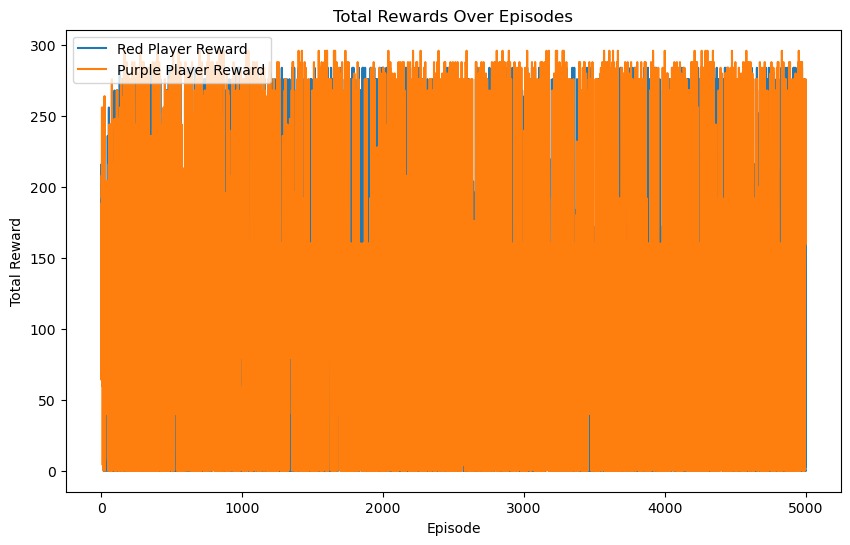

0.0034629942185195827
0.0005218403728734438


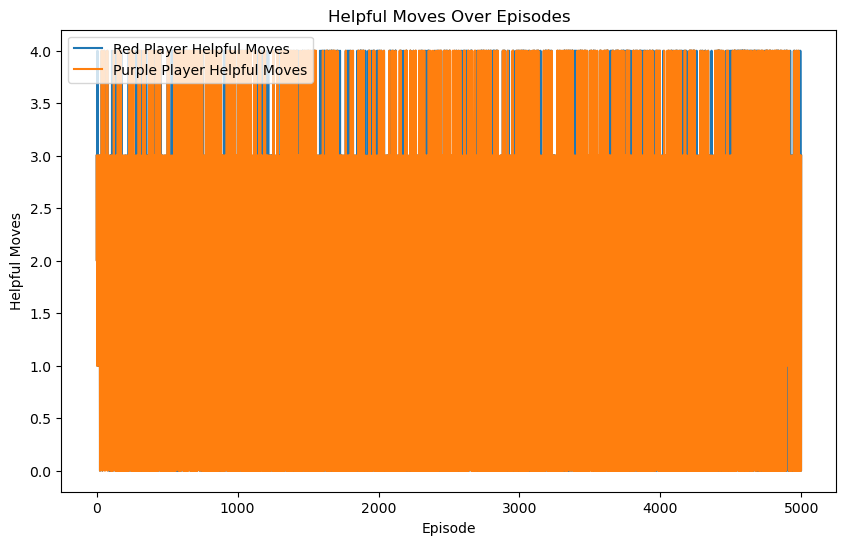

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(final_rewards_red, label="Red Player Reward")
plt.plot(final_rewards_purple, label="Purple Player Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards Over Episodes")
plt.legend()
plt.show()
# Generate x values (indices of the original values)
x = np.arange(len(final_rewards_red))

# Calculate the line of best fit
coefficients = np.polyfit(x, final_rewards_red, 1)
line_of_best_fit = np.poly1d(coefficients)

slope = coefficients[0]
print(slope)

# Calculate the line of best fit
coefficients = np.polyfit(x, final_rewards_purple, 1)
line_of_best_fit = np.poly1d(coefficients)

slope = coefficients[0]
print(slope)

# Example: Plot helpful moves
plt.figure(figsize=(10, 6))
plt.plot(helpful_moves_red, label="Red Player Helpful Moves")
plt.plot(helpful_moves_purple, label="Purple Player Helpful Moves")
plt.xlabel("Episode")
plt.ylabel("Helpful Moves")
plt.title("Helpful Moves Over Episodes")
plt.legend()
plt.show()


In [16]:
def OLS(values):
    # Generate x values (indices of the original values)
    x = np.arange(len(values))

    # Add a constant to the independent variables matrix for the intercept
    X = sm.add_constant(x)

    # Fit the linear regression model
    model = sm.OLS(values, X)
    results = model.fit()

    # Print the summary
    print(results.summary())

    # Extract slope and its confidence interval
    slope = results.params[1]
    slope_ci = results.conf_int()[1]
    print(f"Slope: {slope}, 95% Confidence Interval: {slope_ci}")

    # Plot the original values
    plt.plot(values, 'o', label='Original values')

    # Plot the line of best fit
    plt.plot(x, results.predict(X), '-', label='Line of Best Fit')

    # Add labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Trend of Values with Line of Best Fit')
    plt.legend()
    plt.grid(True)
    plt.show()


In [17]:
total_reward = np.array(final_rewards_red)+np.array(final_rewards_purple)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.154
Date:                Tue, 10 Dec 2024   Prob (F-statistic):            0.00431
Time:                        14:42:15   Log-Likelihood:                -31888.
No. Observations:                5000   AIC:                         6.378e+04
Df Residuals:                    4998   BIC:                         6.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        229.7607      4.028     57.045      0.0

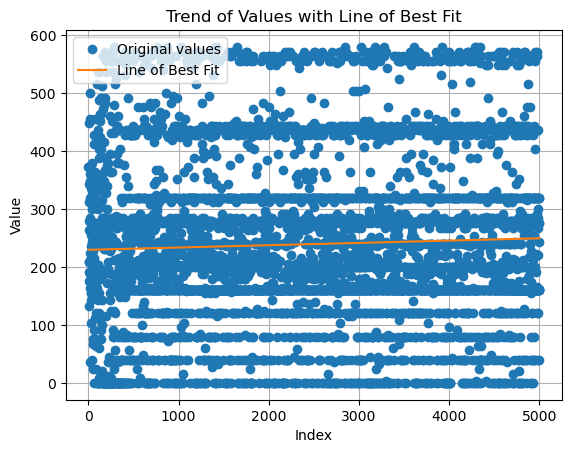

In [18]:
OLS(total_reward)

In [19]:
total_reward[0:1000].mean(),total_reward[-1000:].mean()

(226.94, 247.21)

In [24]:
#Seeing learning!

In [9]:
all_helping = np.array(helpful_moves_red)+np.array(helpful_moves_purple)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.05988
Date:                Tue, 10 Dec 2024   Prob (F-statistic):              0.807
Time:                        14:41:15   Log-Likelihood:                -4833.7
No. Observations:                2000   AIC:                             9671.
Df Residuals:                    1998   BIC:                             9683.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7547      0.121     30.947      0.0

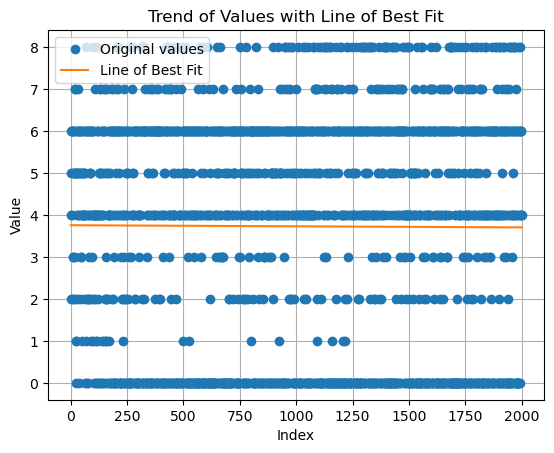

In [10]:
OLS(all_helping)

# walking through step by step 

### setup

In [96]:
agent1 = QLearningAgent(learning_rate=0.15, discount_factor=0.99, epsilon=0.2)
agent2 = QLearningAgent(learning_rate=0.15, discount_factor=0.99, epsilon=0.2)

final_rewards_red = []  # To store the final rewards of the 'red' player
final_rewards_purple = []  # To store the final rewards of the 'purple' player
helpful_moves_red = []  # To track the number of helpful moves for the 'red' player
helpful_moves_purple = []  # To track the number of helpful moves for the 'purple' player

#state = env.reset()  # Reset the environment for a new episode
state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)

#done = False

In [97]:
state.redplayer

{'loc': {'x': 2, 'y': 15},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 100,
 'bonuspoints': 0,
 'has_helped': False}

In [98]:
state.purpleplayer

{'loc': {'x': 3, 'y': 16},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 0,
 'energy': 100,
 'bonuspoints': 0,
 'has_helped': False}

In [99]:
state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
agent1.update(state)
agent2.update(state)

red_helpful_count = 0  # Counter for red's helpful moves
purple_helpful_count = 0  # Counter for purple's helpful moves


### Red takes a step

In [110]:
action1 = agent1.choose_action()
transition = farmgame.Transition(state, action1)
if transition.is_helping():
    red_helpful_count += 1

next_state = state.take_action(action1, inplace=True)
#print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
reward1, done = next_state.reward("red")  # Get reward for the red player
agent1.update_q_value(action1, reward1, next_state)
state = next_state

In [111]:
state.redplayer

{'loc': {'x': 15, 'y': 7},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': []},
 'score': 1,
 'energy': 68,
 'bonuspoints': 0,
 'has_helped': False}

In [106]:
## so red slept, same spot

In [107]:
# Agent 2's turn (Purple)
action2 = agent2.choose_action()
transition = farmgame.Transition(state, action2)
if transition.is_helping():
    purple_helpful_count += 1

next_state = state.take_action(action2, inplace=True)
reward2, done = next_state.reward("purple")  # Get reward for the purple player
agent2.update_q_value(action2, reward2, next_state)
state = next_state

In [108]:
state.purpleplayer

{'loc': {'x': 8, 'y': 7},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x15112f9d0>]},
 'score': 0,
 'energy': 81,
 'bonuspoints': 0,
 'has_helped': True}

In [109]:
# We see purple moved to turnip, but why does it have same backpack capacity
#We see it has backpack content now. So it should be picked up and capacity has not been updated



In [24]:
action1 = agent1.choose_action()
transition = farmgame.Transition(state, action1)
if transition.is_helping():
    red_helpful_count += 1

next_state = state.take_action(action1, inplace=True)
#print("Step taken to " + str(agent1.get_state_representation(agent1.current_state)))
reward1, done = next_state.reward("red")  # Get reward for the red player
agent1.update_q_value(action1, reward1, next_state)
state = next_state
state.redplayer

Exploiting: Chose action Eggplant00(12,14) with Q-value 0.0
Updated Q-value for state-action pair ({'x': 12, 'y': 14}, (<ActionType.veggie: 'veggie'>, 12, 14)): 0.0
Reward: 0, TD Target: 0.0, TD Error: 0.0


{'loc': {'x': 12, 'y': 14},
 'name': 'red',
 'type': 'player',
 'color': 'red',
 'capacity': 4,
 'contents': [<farmgame.Action at 0x281f92a10>,
 'backpack': {'name': 'red',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x281f92a10>,
   <farmgame.Action at 0x281f92ad0>]},
 'score': 0,
 'energy': 87,
 'bonuspoints': 0,
 'has_helped': True}

In [25]:
# Agent 2's turn (Purple)
action2 = agent2.choose_action()
transition = farmgame.Transition(state, action2)
if transition.is_helping():
    purple_helpful_count += 1

next_state = state.take_action(action2, inplace=True)
reward2, done = next_state.reward("purple")  # Get reward for the purple player
agent2.update_q_value(action2, reward2, next_state)
state = next_state
state.purpleplayer

Exploiting: Chose action Turnip01(13,13) with Q-value 0.0
Updated Q-value for state-action pair ({'x': 13, 'y': 13}, (<ActionType.veggie: 'veggie'>, 13, 13)): 0.0
Reward: 0, TD Target: 0.0, TD Error: 0.0


{'loc': {'x': 13, 'y': 13},
 'name': 'purple',
 'type': 'player',
 'color': 'purple',
 'capacity': 4,
 'contents': [],
 'backpack': {'name': 'purple',
  'type': 'backpack',
  'capacity': 4,
  'contents': [<farmgame.Action at 0x281f93210>]},
 'score': 0,
 'energy': 82,
 'bonuspoints': 0,
 'has_helped': False}

In [26]:
state.all_objects_picked_up('purple')

AttributeError: 'Farm' object has no attribute 'all_objects_picked_up'

In [ ]:
#now it should have two things in the backpack? Only 1?
#why is the location the same if it went to eggplant?
